In [41]:
# Core data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Spatial clustering and distance structures
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial import cKDTree

# Network analysis
import networkx as nx
from networkx.algorithms import community

# Utilities
from collections import defaultdict
from tqdm.auto import tqdm

# Analyze trend over time
from scipy.stats import linregress

# Import configuration
import constants
from pathlib import Path


# Blackpoll Warbler migration – data preparation

In this section, we load the eBird sample for Blackpoll Warbler, clean basic issues
(missing values, inconsistent observation counts), and restrict the data to a recent
time window. The goal is to obtain a clean observation-level dataset that is ready
for spatial clustering and subsequent network construction.


In [42]:
# File path for Blackpoll Warbler observations
BASE_DIR = Path.cwd()
BKPWAR_PATH = BASE_DIR / constants.BKPWAR_PATH
# Load dataset
df_bkpwar = pd.read_csv(
    BKPWAR_PATH,
    sep="\t",
    usecols=constants.BIRD_COLS,
    low_memory=False,
)

# Null check
print("Null values df_bkpwar:\n", df_bkpwar.isna().sum())

# Total number of rows in the dataset
total_rows = len(df_bkpwar)
print(f"Total number of rows in df_bkpwar: {total_rows}")

Null values df_bkpwar:
 GLOBAL UNIQUE IDENTIFIER        0
COMMON NAME                     0
OBSERVATION COUNT               0
COUNTRY                         0
STATE                           0
COUNTY                      41795
LOCALITY                        0
LATITUDE                        1
LONGITUDE                       1
OBSERVATION DATE                1
dtype: int64
Total number of rows in df_bkpwar: 1182669


In [43]:
df_bkpwar["OBSERVATION DATE"] = pd.to_datetime(df_bkpwar["OBSERVATION DATE"])
df_bkpwar = df_bkpwar.sort_values(by="OBSERVATION DATE", ascending=False).reset_index(drop=True)

In [44]:
df_bkpwar.head(2)

,GLOBAL UNIQUE IDENTIFIER,COMMON NAME,OBSERVATION COUNT,COUNTRY,STATE,COUNTY,LOCALITY,LATITUDE,LONGITUDE,OBSERVATION DATE
0,URN:CornellLabOfOrnithology:EBIRD:OBS3713391932,Blackpoll Warbler,1,Venezuela,Miranda,NaN,Marquesal,10.494748,-66.804030,2025-10-31
1,URN:CornellLabOfOrnithology:EBIRD:OBS3714532106,Blackpoll Warbler,2,Guadeloupe,Guadeloupe,NaN,Chemin des Lataniers (La Désirade),16.299182,-61.095336,2025-10-31


In [45]:
#dropping COUNTY column
df_bkpwar.drop(columns=["COUNTY"], inplace=True)
#Drops all rows with null value in any column
df_bkpwar.dropna(inplace=True)

In [46]:
# Replacing "X" (unknown positive count) of observation with 1 and converting to integer
df_bkpwar["OBSERVATION COUNT"] = (
    df_bkpwar["OBSERVATION COUNT"]
    .replace("X", 1)
    .astype(int)
)

In [47]:
print("Total birds observed", df_bkpwar["OBSERVATION COUNT"].sum())

Total birds observed 2935819


## Time filtering: focus on recent decade

Migration patterns can change over long time scales. To focus on contemporary
behavior and reduce historical noise, we restrict the dataset to the most recent
10 years of observations. 


In [48]:
def filter_recent_years(df, years):
    """Return only observations from the most recent years"""
    max_date = df["OBSERVATION DATE"].max()
    cutoff_date = max_date - pd.DateOffset(years=years)
    return df[df["OBSERVATION DATE"] >= cutoff_date].copy()

df_bkpwar_recent = filter_recent_years(df_bkpwar, years=constants.YEARS_RECENT)

print(f"Data after filtering to recent decade: {len(df_bkpwar_recent):,} records")
print(
    f"Date range: {df_bkpwar_recent['OBSERVATION DATE'].min()} "
    f"to {df_bkpwar_recent['OBSERVATION DATE'].max()}"
)

Data after filtering to recent decade: 891,533 records
Date range: 2015-10-31 00:00:00 to 2025-10-31 00:00:00


# Spatial clustering: defining spatial nodes

To move from raw observations to a network representation, we first need to define
spatial regions that will act as nodes in the graph. We use density-based spatial
clustering (DBSCAN) on latitude/longitude coordinates to identify coherent spatial
clusters. Each observation will later be assigned to one of these clusters.

The function below implements a custom DBSCAN variant using a KD-tree for efficient
neighbor queries on large point sets.

In [49]:
def custom_dbscan_kdtree(points, eps, min_samples):
    """
    Custom DBSCAN implementation using a KD-tree for fast neighborhood queries.

    Parameters
    ----------
    points : ndarray of shape (n_points, n_dims)
        Input coordinates (e.g., latitude/longitude projected to km).
    eps : float
        Maximum distance for two points to be considered neighbors.
    min_samples : int
        Minimum number of points (including itself) required to form a core point.

    Returns
    -------
    labels : ndarray of shape (n_points,)
        Cluster labels for each point.
        -1 denotes noise.
    """

    from collections import deque
    import numpy as np
    from scipy.spatial import cKDTree

    # Build KD-tree for efficient epsilon-neighborhood queries
    tree = cKDTree(points)

    # Precompute neighbors for every point (epsilon-neighborhood graph)
    neighbors = tree.query_ball_point(points, eps, workers=-1)

    n_points = len(points)

    # Label conventions
    UNVISITED = -99
    NOISE = -1

    # Initialize all points as unvisited
    labels = np.full(n_points, UNVISITED, dtype=np.int32)

    current_cluster_id = 0

    # Iterate over all points
    for i in range(n_points):

        # Skip if already processed
        if labels[i] != UNVISITED:
            continue

        # If not a core point, mark as noise
        if len(neighbors[i]) < min_samples:
            labels[i] = NOISE
            continue

        # Start a new cluster
        labels[i] = current_cluster_id

        # Queue for breadth-first expansion (THIS FIXES THE 1-HOP ISSUE)
        queue = deque(neighbors[i])

        # Expand cluster via density connectivity
        while queue:
            j = queue.popleft()

            # If previously marked as noise, reassign as border point
            if labels[j] == NOISE:
                labels[j] = current_cluster_id

            # Skip if already assigned to a cluster
            if labels[j] != UNVISITED:
                continue

            # Assign point j to the current cluster
            labels[j] = current_cluster_id

            # If j is a core point, expand further from it
            if len(neighbors[j]) >= min_samples:
                for n in neighbors[j]:
                    if labels[n] in (UNVISITED, NOISE):
                        queue.append(n)

        # Move to the next cluster
        current_cluster_id += 1

    return labels


## Aggregating very close observations

Many eBird observations are extremely close in space. Before running DBSCAN, we group observations into small
latitude/longitude grid cells (~1.1 km at 0.01 degrees). Within each grid cell we:

- Average the coordinates to obtain a single representative point.
- Sum observation counts to keep track of total birds.
- Keep the most common state label.

This reduces noise and speeds up clustering without changing the large-scale
spatial structure of the data.


Fixed the previous code  with recursive neighborhood expansion using a queue, ensuring clusters reflect full density connectivity rather than only immediate neighbors.

In [50]:
def aggregate_close_observations(obs_df, precision_deg=0.01):
    """
    Group observations that fall into the same small lat/lon grid cell.

    precision_deg controls the grid size (0.01 degrees ≈ 1.1 km).
    """
    df = obs_df.copy()

    # Snap coordinates to a regular grid
    df["lat_rounded"] = (df["LATITUDE"] / precision_deg).round() * precision_deg
    df["lon_rounded"] = (df["LONGITUDE"] / precision_deg).round() * precision_deg

    # Aggregate all observations in the same grid cell
    agg_df = (
        df.groupby(["lat_rounded", "lon_rounded"])
          .agg({
              "LATITUDE": "mean",
              "LONGITUDE": "mean",
              "OBSERVATION COUNT": "sum",
              "STATE": lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown",
          })
          .reset_index()
    )

    print(
        f"Grid aggregation: {len(obs_df):,} observations → "
        f"{len(agg_df):,} grid points"
    )
    return agg_df

## Clustering aggregated points in space

After grid aggregation, we cluster the resulting points using the custom DBSCAN
implementation. The main parameters are:

- `eps_km`: neighborhood radius in kilometers (here, default 25 km).
- `min_samples`: minimum number of nearby points required to form a dense region.

The output of this step is a set of spatial clusters, each identified by a
`cluster_id`. These clusters represent candidate spatial nodes for the migration
network, but we still need to map each original observation to its nearest cluster.


In [51]:
def cluster_aggregated_points(agg_points_df, eps_km=25, min_samples=3):
    """
    Run custom DBSCAN on the aggregated grid points. (non-batched version)

    Returns
    -------
    clustered_points_df : pd.DataFrame
        Copy of agg_points_df with a 'cluster_id' column.
    eps_deg : float
        Neighborhood radius in degrees, used later for distance checks.
    """
    clustered_points_df = agg_points_df.copy()

    # Coordinates used for clustering
    coords = clustered_points_df[["LATITUDE", "LONGITUDE"]].values

    # Convert neighborhood radius from kilometers to degrees (roughly)
    eps_deg = eps_km / 111.0  # 1 degree ≈ 111 km on Earth

    print(
        f"Clustering {len(clustered_points_df):,} grid points "
        f"with eps ≈ {eps_km} km (≈ {eps_deg:.4f} degrees), "
        f"min_samples = {min_samples}..."
    )

    # For now, cluster everything at once (fine for moderate sizes)
    labels = custom_dbscan_kdtree(coords, eps_deg, min_samples)
    clustered_points_df["cluster_id"] = labels

    # You can later plug in your batched logic here if needed for very large data
    return clustered_points_df, eps_deg


## Assigning observations to spatial clusters

Once DBSCAN has identified spatial clusters, we assign each original observation
to its nearest cluster centroid. This gives every observation a `cluster_id` that
tells us which spatial region it belongs to.

Observations that are too far away from all cluster centroids (relative to the
chosen `eps_km`) are treated as noise and assigned `cluster_id = -1`. These can
be excluded from the network or handled separately if needed.


In [52]:
def assign_observations_to_clusters(obs_df, clustered_points_df, eps_deg):
    """
    For each observation, find the nearest cluster centroid and assign its cluster_id.

    Observations farther than 2 * eps_deg away from any centroid are marked as noise (-1).

    Returns
    -------
    obs_with_clusters : copy of obs_df with an added 'cluster_id' column.
    """

    # Keep only valid clusters (ignore DBSCAN noise)
    valid_clusters = clustered_points_df[clustered_points_df["cluster_id"] != -1]
    cluster_ids_array = valid_clusters["cluster_id"].values

    # Store original observation coordinates
    obs_with_clusters = obs_df.copy()
    obs_coords = obs_with_clusters[["LATITUDE", "LONGITUDE"]].values

    # Build a KD-tree over cluster centroids
    cluster_coords = valid_clusters[["LATITUDE", "LONGITUDE"]].values
    cluster_tree = cKDTree(cluster_coords)

    # For each observation, find the index of the nearest cluster centroid
    distances, nearest_idx = cluster_tree.query(obs_coords, k=1, workers=-1)

    obs_with_clusters["cluster_id"] = cluster_ids_array[nearest_idx]

    # Observations too far from every cluster centroid are treated as noise
    max_dist_deg = eps_deg * 2.0  # small buffer above eps
    obs_with_clusters.loc[distances > max_dist_deg, "cluster_id"] = -1

    return obs_with_clusters


## Building a cluster-level node table

To analyze the migration network, we need a node table describing each spatial
cluster. For every `cluster_id`, we compute:

- A weighted centroid position.
- The number of observations and total birds.
- The first and last observation dates within the cluster.
- A dominant state label.
- A rough area estimate.


In [53]:
def build_cluster_node_table(obs_with_clusters, eps_km=25):
    """
    Summarize each spatial cluster as a node with spatial and temporal attributes.

    Returns
    -------
    cluster_nodes_df : One row per cluster_id with centroid, counts, and time range.
    """
    cluster_records = []

    for cid in np.unique(obs_with_clusters["cluster_id"]):
        if cid == -1:
            continue  # skip noise

        # Get all observations in this cluster
        cluster_obs = obs_with_clusters[obs_with_clusters["cluster_id"] == cid]

        # Compute a centroid; use observation counts as weights
        weights = cluster_obs["OBSERVATION COUNT"].fillna(1).values
        centroid_lat = np.average(cluster_obs["LATITUDE"].values, weights=weights)
        centroid_lon = np.average(cluster_obs["LONGITUDE"].values, weights=weights)

        cluster_records.append({
            "cluster_id": int(cid),
            "centroid_lat": centroid_lat,
            "centroid_lon": centroid_lon,
            "n_observations": len(cluster_obs),
            "total_birds": cluster_obs["OBSERVATION COUNT"].sum(),
            "first_seen": cluster_obs["OBSERVATION DATE"].min(),
            "last_seen": cluster_obs["OBSERVATION DATE"].max(),
            "state": (
                cluster_obs["STATE"].mode().iloc[0]
                if not cluster_obs["STATE"].mode().empty
                else "Unknown"
            )
        })

    cluster_nodes_df = pd.DataFrame(cluster_records)
    print(f"Cluster summary: {len(cluster_nodes_df)} clusters")
    return cluster_nodes_df


# From observations to spatial nodes

The helper functions above are combined into a small pipeline. Starting from the
cleaned and time-filtered Blackpoll Warbler observations, the pipeline:

1. Aggregates very close observations into grid cells.
2. Clusters the grid points using DBSCAN to obtain spatial clusters.
3. Assigns each original observation to its nearest cluster.
4. Builds a node table summarizing each cluster.

This produces two key objects:

- `df_bkpwar_clusters`: observation-level data, where each observation carries
  a `cluster_id` and a timestamp.
- `nodes_bkpwar`: node table (one row per spatial cluster) for network analysis.


In [54]:
def run_spatial_clustering_pipeline(obs_df, eps_km=25, min_samples=3):
    """
    From cleaned bird observations to:
      1) observations with cluster_id,
      2) cluster node table suitable for network analysis.
    """
    # 1) Group very nearby points to reduce noise and size
    agg_points_df = aggregate_close_observations(obs_df)

    # 2) Cluster the aggregated points in space
    clustered_points_df, eps_deg = cluster_aggregated_points(
        agg_points_df,
        eps_km=eps_km,
        min_samples=min_samples,
    )

    # 3) Assign each original observation to its nearest cluster
    obs_with_clusters = assign_observations_to_clusters(
        obs_df,
        clustered_points_df,
        eps_deg,
    )

    # 4) Create a node table (one row per cluster)
    cluster_nodes_df = build_cluster_node_table(
        obs_with_clusters,
        eps_km=eps_km,
    )

    return obs_with_clusters, cluster_nodes_df


In [55]:
df_bkpwar_clusters, nodes_bkpwar = run_spatial_clustering_pipeline(df_bkpwar_recent,eps_km=constants.EPS_KM,min_samples=constants.MIN_SAMPLES,)

Grid aggregation: 891,533 observations → 94,905 grid points
Clustering 94,905 grid points with eps ≈ 25 km (≈ 0.2252 degrees), min_samples = 3...
Cluster summary: 816 clusters


In [56]:
# Quick sanity checks
print(df_bkpwar_clusters[["LATITUDE", "LONGITUDE", "OBSERVATION DATE", "cluster_id"]].head())
print(nodes_bkpwar.head(2))

   LATITUDE  LONGITUDE OBSERVATION DATE  cluster_id
0 10.494748 -66.804030       2025-10-31          99
1 16.299182 -61.095336       2025-10-31         126
2 16.299182 -61.095336       2025-10-31         126
3 41.735262 -70.384769       2025-10-31         223
4 16.299984 -61.094594       2025-10-31         126
   cluster_id  centroid_lat  centroid_lon  n_observations  total_birds  \
0           0    -23.796707    -46.527789              25           26   
1           1     -6.640542    -76.298839              11           11   

  first_seen  last_seen       state  
0 2019-12-09 2024-01-30   São Paulo  
1 2017-02-10 2024-12-05  San Martín  


# Edge Creation

## Methodological Considerations

An initial approach based on individual bird trajectories resulted in graphs
where each node had in-degree and out-degree at most one, forming simple path
structures. In such graphs, most network science measures (e.g., clustering
coefficient, community detection) are not meaningful.

Recognizing this limitation, we reformulated the network to represent aggregated
flows between clusters across time. This shift transforms the graph into a
true network with heterogeneous degree distributions, allowing for meaningful
application of network science concepts.


In [57]:
# -----------------------------
# Temporal columns
# -----------------------------
df_bkpwar_clusters["year"] = df_bkpwar_clusters["OBSERVATION DATE"].dt.year
df_bkpwar_clusters["month"] = df_bkpwar_clusters["OBSERVATION DATE"].dt.month

graphs_by_year = {}

# -----------------------------
# Build networks year by year
# -----------------------------
for year, year_df in tqdm(
    df_bkpwar_clusters.groupby("year"),
    desc="Building yearly temporal networks"
):
    year_df = year_df.sort_values("OBSERVATION DATE")

    # --- drop noise observations ---
    year_df = year_df[year_df["cluster_id"] != -1].copy()

    # ---- Active clusters this year ----
    active_clusters = set(year_df["cluster_id"].unique())

    # ---- Initialize graph ----
    G = nx.DiGraph(year=year)

    # ---- Add only ACTIVE nodes with attributes ----
    nodes_year = nodes_bkpwar[nodes_bkpwar["cluster_id"].isin(active_clusters)]

    for _, row in nodes_year.iterrows():
        node_id = row["cluster_id"]
        attrs = row.drop("cluster_id").to_dict()
        G.add_node(node_id, **attrs)

    # ---- Group observations by month ----
    monthly_groups = year_df.groupby("month", sort=True)
    months = list(monthly_groups.groups.keys())

    edge_weights = defaultdict(float)

    for i in range(len(months) - 1):
        m_t = months[i]
        m_t1 = months[i + 1]

        # skip gaps
        if m_t1 != m_t + 1:
            continue

        df_t = monthly_groups.get_group(m_t)
        df_t1 = monthly_groups.get_group(m_t1)

        counts_t = df_t.groupby("cluster_id")["OBSERVATION COUNT"].sum()
        counts_t1 = df_t1.groupby("cluster_id")["OBSERVATION COUNT"].sum()

        total_t1 = counts_t1.sum()

        for u, c_u in counts_t.items():
            candidates = []

            for v, c_v in counts_t1.items():
                w = c_v / total_t1  # normalized by destination month
                candidates.append((v, w))

            if not candidates:
                continue

            candidates.sort(key=lambda x: x[1], reverse=True)
            max_w = candidates[0][1]

            kept = [(v, w) for v, w in candidates if w >= constants.MIN_FRAC * max_w]

            if len(kept) < constants.K_EDGES:
                kept = candidates[:constants.K_EDGES]

            for v, w in kept:
                edge_weights[(u, v)] += w

    # ---- Add edges ----
    for (u, v), w in edge_weights.items():
        if w > 0:
            G.add_edge(u, v, weight=w)

    # ---- Remove isolated nodes ----
    G.remove_nodes_from(list(nx.isolates(G)))

    graphs_by_year[year] = G


Building yearly temporal networks:   0%|          | 0/11 [00:00<?, ?it/s]

In [58]:
for year, G in graphs_by_year.items():
    degrees = dict(G.degree())
    strengths = dict(G.degree(weight="weight"))

    print(
        f"Year {year}:",
        f"nodes={G.number_of_nodes()}",
        f"edges={G.number_of_edges()}",
        f"max_degree={max(degrees.values()) if degrees else 0}"
    )

Year 2015: nodes=37 edges=382 max_degree=50
Year 2016: nodes=367 edges=5474 max_degree=399
Year 2017: nodes=422 edges=6535 max_degree=464
Year 2018: nodes=458 edges=7075 max_degree=491
Year 2019: nodes=472 edges=7129 max_degree=498
Year 2020: nodes=472 edges=7227 max_degree=499
Year 2021: nodes=510 edges=7887 max_degree=540
Year 2022: nodes=534 edges=8386 max_degree=570
Year 2023: nodes=552 edges=8797 max_degree=567
Year 2024: nodes=526 edges=8345 max_degree=560
Year 2025: nodes=529 edges=8173 max_degree=550


We restrict our analysis to the period 2016–2024. The year 2015 was excluded due to insufficient spatial coverage, and 2025 was excluded as it represents a partial year with incomplete migration data. This ensures comparability of network structure across years.

Full spatial "pool": 816 clusters (all time)

Yearly active clusters: 368–553 (2016–2024)

Percent active per year: (368/816) to (553/816) = 45–68%


In [59]:
for y in [2015, 2025]:
    graphs_by_year.pop(y, None)

In [60]:
df_bkpwar_clusters = df_bkpwar_clusters[
    df_bkpwar_clusters["year"].between(2016, 2024)
]

In [61]:
print(sorted(df_bkpwar_clusters["year"].unique()))

[np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


## Network Analysis

In [62]:
summary = []
for year in sorted(graphs_by_year):
    G = graphs_by_year[year]
    deg = np.array([d for _, d in G.degree()])
    strw = np.array([s for _, s in G.degree(weight="weight")])

    if deg.size:
        dp = np.percentile(deg, [50, 75, 90, 99])
    else:
        dp = [np.nan] * 4

    if strw.size:
        sp = np.percentile(strw, [50, 75, 90, 99])
    else:
        sp = [np.nan] * 4

    summary.append({
        "year": year,
        "deg_p50": dp[0], "deg_p75": dp[1], "deg_p90": dp[2], "deg_p99": dp[3],
        "str_p50": sp[0], "str_p75": sp[1], "str_p90": sp[2], "str_p99": sp[3],
    })

percentiles_df = pd.DataFrame(summary).sort_values("year").reset_index(drop=True)
display(percentiles_df)

,year,deg_p50,deg_p75,deg_p90,deg_p99,str_p50,str_p75,str_p90,str_p99
0,2016,12.000000,19.500000,62.600000,301.120000,1.252747,2.270383,3.812667,28.769504
1,2017,10.000000,20.000000,67.800000,313.590000,0.963398,1.863131,4.169455,31.003517
2,2018,10.000000,21.000000,56.000000,340.290000,0.988464,2.613284,3.673674,26.505487
3,2019,10.000000,19.000000,37.000000,374.350000,0.930957,2.605962,3.700145,22.424724
4,2020,10.000000,18.000000,44.000000,370.000000,0.989698,1.946512,3.840747,21.204104
5,2021,10.000000,19.000000,42.000000,390.740000,0.980967,2.559198,3.770190,25.565758
6,2022,12.000000,19.000000,43.700000,407.350000,1.709568,1.932115,3.798177,31.257147
7,2023,12.000000,20.000000,44.600000,426.410000,0.985318,2.126789,3.768516,32.143265
8,2024,13.000000,19.000000,51.000000,390.750000,1.383865,2.600359,4.457996,38.374052


From 2016 → 2024,

Most birds funnel through fewer, more critical routes

Super-hubs (99th percentile degree) become MORE connected (+90 degree 2016-2024)
Super-hub traffic intensifies (+9 strength 2016-2024)

## Path Length

In [63]:
def analyze_evolution_bootstrap(edges_df, cluster_nodes, start_year=2016, n_iterations=100):
    edge_year_flat = edges_df.explode('years').rename(columns={'years': 'year'})
    edge_year_flat = edge_year_flat[edge_year_flat['year'] >= start_year]
    
    yearly_counts = edge_year_flat.groupby('year').size()
    min_edges = yearly_counts.min()
    
    results = []
    all_years = sorted(edge_year_flat['year'].unique())

    for year in all_years:
        year_pool = edge_year_flat[edge_year_flat['year'] == year]
        
        # Lists to store metrics for bootstrap iterations
        it_diameters = []
        it_paths = []
        it_90th_paths = []
        it_lwcc_size = []

        print(f"Bootstrapping Year {year}...")
        for i in range(n_iterations):
            # 1. Bootstrap: Sample with replacement (or without if you prefer rarefaction)
            sub_edges = year_pool.sample(n=min_edges, replace=True)
            
            G = nx.DiGraph()
            G.add_edges_from(zip(sub_edges['source'], sub_edges['target']))
            
            if G.number_of_edges() > 0:
                # 2. Extract LWCC and size
                lwcc_nodes = max(nx.weakly_connected_components(G), key=len)
                lwcc_ratio = len(lwcc_nodes) / cluster_nodes.shape[0]
                it_lwcc_size.append(lwcc_ratio)
                
                # 3. Path calculations (Undirected for diameter/90th)
                subgraph = G.subgraph(lwcc_nodes).copy()
                
                # All shortest path lengths
                path_lengths = []
                spl = dict(nx.all_pairs_shortest_path_length(subgraph))
                for source in spl:
                    for target in spl[source]:
                        if source != target:
                            path_lengths.append(spl[source][target])
                
                if path_lengths:
                    it_diameters.append(max(path_lengths))
                    it_paths.append(np.mean(path_lengths))
                    it_90th_paths.append(np.percentile(path_lengths, 90))
            
        results.append({
            'year': year,
            'diam_mean': np.mean(it_diameters),
            'diam_std': np.std(it_diameters),
            'path_mean': np.mean(it_paths),
            'path_std': np.std(it_paths),
            'path_90th_mean': np.mean(it_90th_paths),
            'lwcc_size_mean': np.mean(it_lwcc_size)
        })

    return pd.DataFrame(results)

In [64]:
all_edges_list = []
for year, G_year in graphs_by_year.items():
    for u, v in G_year.edges():
        all_edges_list.append({'source': u, 'target': v, 'years': year})

# Create edges DataFrame
edges_df = pd.DataFrame(all_edges_list)
edges_df['years'] = edges_df['years'].apply(lambda x: [x])

# 3. Get your cluster_nodes as a DataFrame
nodes_df = nodes_bkpwar

In [65]:
bootstrap_df = analyze_evolution_bootstrap(edges_df, nodes_df)
print(bootstrap_df)

Bootstrapping Year 2016...
Bootstrapping Year 2017...
Bootstrapping Year 2018...
Bootstrapping Year 2019...
Bootstrapping Year 2020...
Bootstrapping Year 2021...
Bootstrapping Year 2022...
Bootstrapping Year 2023...
Bootstrapping Year 2024...
   year  diam_mean  diam_std  path_mean  path_std  path_90th_mean  \
0  2016   4.050000  0.259808   2.093092  0.013062        3.000000   
1  2017   4.070000  0.255147   2.161681  0.013421        3.000000   
2  2018   4.090000  0.286182   2.151698  0.014755        3.000000   
3  2019   4.010000  0.099499   2.123300  0.014050        3.000000   
4  2020   4.060000  0.237487   2.125098  0.011868        3.000000   
5  2021   4.280000  0.448999   2.194610  0.016996        3.000000   
6  2022   4.160000  0.366606   2.165935  0.015966        3.000000   
7  2023   4.020000  0.140000   2.162874  0.013836        3.000000   
8  2024   4.070000  0.255147   2.150215  0.014547        3.000000   

   lwcc_size_mean  
0        0.449743  
1        0.517120  
2     

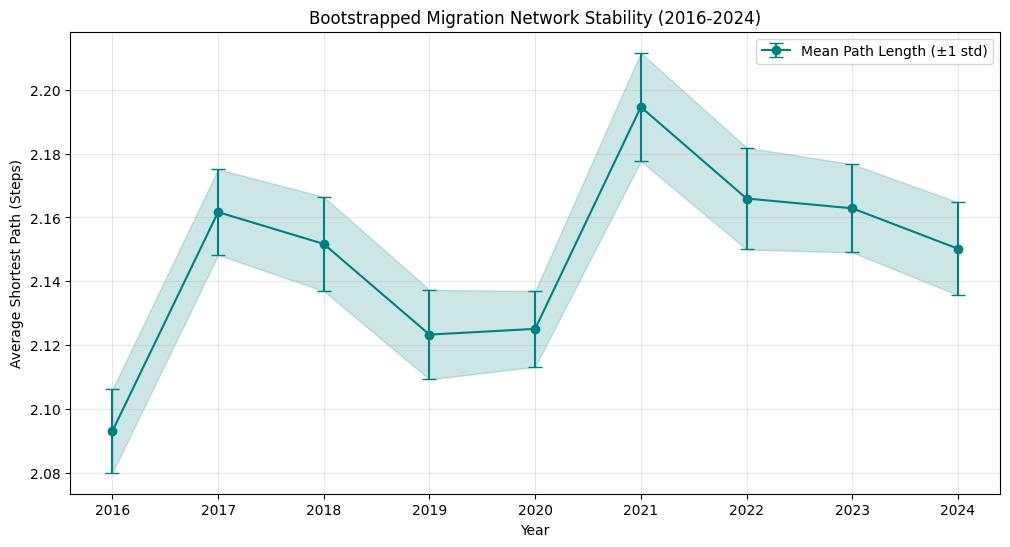

In [66]:
plt.figure(figsize=(12, 6))

# Plotting Path Mean with Standard Deviation as a shaded area
plt.errorbar(bootstrap_df['year'], bootstrap_df['path_mean'], 
             yerr=bootstrap_df['path_std'], fmt='-o', capsize=5, 
             label='Mean Path Length (±1 std)', color='teal')

plt.fill_between(bootstrap_df['year'], 
                 bootstrap_df['path_mean'] - bootstrap_df['path_std'],
                 bootstrap_df['path_mean'] + bootstrap_df['path_std'], 
                 alpha=0.2, color='teal')

plt.title('Bootstrapped Migration Network Stability (2016-2024)')
plt.xlabel('Year')
plt.ylabel('Average Shortest Path (Steps)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Small-world characteristics:

Low average path length ($\approx 2.1$ to $2.2$) and diameter ($\approx 4$), indicating long-distance connectivity. A bird can move to far away regions using few intermediate stopovers.

"Hub" clusters (major stopover sites or breeding grounds) that connect many disparate areas.

90% of all possible paths (for every single year) have a length of 3 steps of fewer.

Clear Upward Trend in LWCC (Largest Weakly Connected Component):

New connections are appearing between peripheral nodes and the main body of the network. 

Average Shortest Path in 2021 Peak:

The average shortest path increases in 2021. This might be likely to the fact that LWCC also increased considerably this year. The reason behind might be that when integrating peripheral nodes into the main body of the network, those nodes are usually far from the center. This leads to an increase in the average path length. All in all, 2021 peak likely represents a yeat where a the network captured a lot of distant, previously isolated clusters.


## Community Detection

In [67]:
community_results = []
communities_by_year = {}

for year, G in sorted(graphs_by_year.items()):
    # Convert to undirected for community detection
    G_undirected = G.to_undirected()
    
    # Detect communities using greedy modularity optimization
    communities = list(
        community.greedy_modularity_communities(
            G_undirected, weight='weight'
        )
    )
    
    # Store communities for later tracking / visualization
    communities_by_year[year] = communities
    
    # Compute modularity score
    modularity = community.modularity(
        G_undirected, communities, weight='weight'
    )
    
    # Compute community sizes
    community_sizes = sorted([len(c) for c in communities], reverse=True)
    
    community_results.append({
        'year': year,
        'num_communities': len(communities),
        'modularity': modularity,
        'largest_community_size': community_sizes[0] if community_sizes else 0,
        'community_sizes': community_sizes
    })
    
    print(
        f"{year}: {len(communities)} communities, "
        f"modularity={modularity:.3f}, sizes={community_sizes}"
    )

# Create DataFrame for trend analysis
community_df = pd.DataFrame(community_results)
display(
    community_df[
        ['year', 'num_communities', 'modularity', 'largest_community_size']
    ]
)

# Trend analysis: Are corridors fragmenting?
slope_comm, intercept_comm, r_value_comm, p_value_comm, std_err_comm = linregress(
    community_df['year'], 
    community_df['num_communities']
)

slope_mod, intercept_mod, r_value_mod, p_value_mod, std_err_mod = linregress(
    community_df['year'], 
    community_df['modularity']
)

2016: 3 communities, modularity=0.245, sizes=[163, 118, 86]
2017: 3 communities, modularity=0.248, sizes=[175, 151, 96]
2018: 3 communities, modularity=0.234, sizes=[190, 170, 98]
2019: 2 communities, modularity=0.229, sizes=[351, 121]
2020: 2 communities, modularity=0.189, sizes=[372, 100]
2021: 3 communities, modularity=0.229, sizes=[212, 183, 115]
2022: 3 communities, modularity=0.262, sizes=[209, 204, 121]
2023: 3 communities, modularity=0.268, sizes=[219, 196, 137]
2024: 3 communities, modularity=0.290, sizes=[197, 189, 140]


,year,num_communities,modularity,largest_community_size
0,2016,3,0.245402,163
1,2017,3,0.248273,175
2,2018,3,0.233985,190
3,2019,2,0.229432,351
4,2020,2,0.189246,372
5,2021,3,0.229331,212
6,2022,3,0.262373,209
7,2023,3,0.268209,219
8,2024,3,0.289792,197


No significant trend in the number of communities

In [68]:
for year in [2016, 2020, 2024]:
    
    communities = communities_by_year[year]

    print("\n" + "=" * 70)
    print(f"\nYear {year}: {len(communities)} communities")
    
    for i, comm in enumerate(communities, 1):
        comm_nodes = list(comm)

        comm_df = nodes_bkpwar[
            nodes_bkpwar['cluster_id'].isin(comm_nodes)
        ]

        if len(comm_df) == 0:
            continue

        print(f"\n  Community {i}: {len(comm_nodes)} clusters")
        print(
            f"    Latitude range: "
            f"{comm_df['centroid_lat'].min():.2f}° "
            f"to {comm_df['centroid_lat'].max():.2f}°"
        )
        print(
            f"    Longitude range: "
            f"{comm_df['centroid_lon'].min():.2f}° "
            f"to {comm_df['centroid_lon'].max():.2f}°"
        )
        print(
            f"    Center: "
            f"({comm_df['centroid_lat'].mean():.2f}°, "
            f"{comm_df['centroid_lon'].mean():.2f}°)"
        )

        states_in_comm = comm_df['state'].value_counts()
        print(
            f"    Top states: "
            f"{', '.join(states_in_comm.head(3).index.tolist())}"
        )



Year 2016: 3 communities

  Community 1: 163 clusters
    Latitude range: 19.32° to 66.24°
    Longitude range: -164.98° to -53.27°
    Center: (50.32°, -109.98°)
    Top states: Alaska, Yukon Territory, Quebec

  Community 2: 118 clusters
    Latitude range: 8.38° to 64.82°
    Longitude range: -147.65° to -56.19°
    Center: (41.74°, -94.69°)
    Top states: Alberta, North Dakota, Texas

  Community 3: 86 clusters
    Latitude range: -6.03° to 46.82°
    Longitude range: -123.00° to -52.29°
    Center: (14.69°, -77.07°)
    Top states: California, Meta, Antioquia


Year 2020: 2 communities

  Community 1: 372 clusters
    Latitude range: 8.61° to 65.29°
    Longitude range: -161.65° to -53.27°
    Center: (43.77°, -100.72°)
    Top states: Alberta, North Dakota, Alaska

  Community 2: 100 clusters
    Latitude range: -23.80° to 60.30°
    Longitude range: -102.54° to -1.34°
    Center: (12.28°, -70.64°)
    Top states: Meta, Arauca, Falcón


Year 2024: 3 communities

  Community 1:

In [69]:
node_community_by_year = {}

for year, communities in communities_by_year.items():
    node_community_by_year[year] = {}

    for label, comm in enumerate(communities):
        for node in comm:
            node_community_by_year[year][node] = label

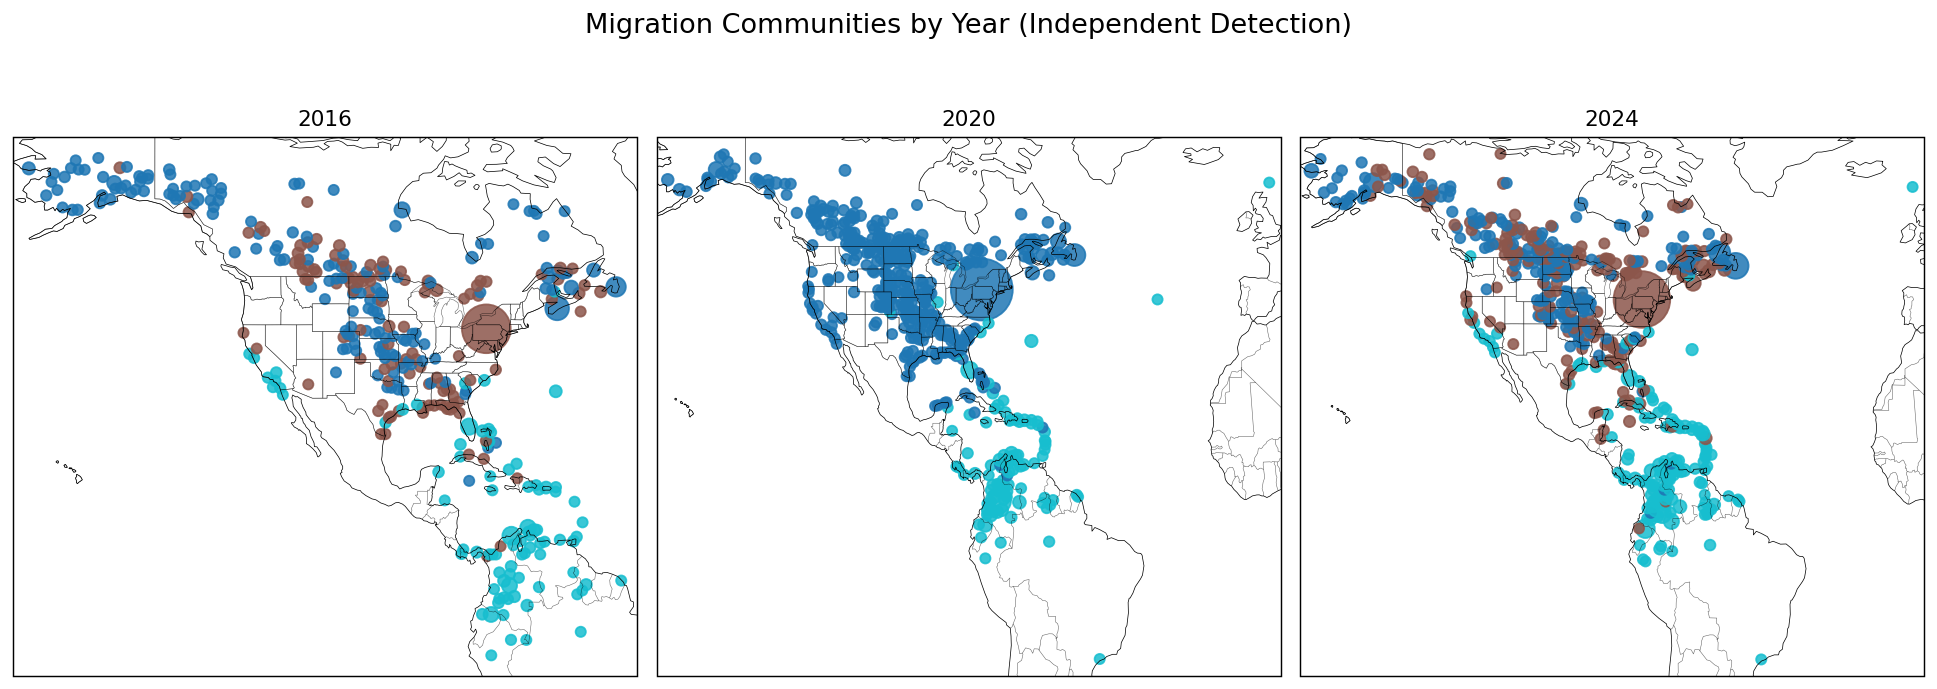

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

years_to_plot = [2016, 2020, 2024]

fig, axes = plt.subplots(
    1, 3,
    figsize=(15, 5),
    dpi=130,
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ax, year in zip(axes, years_to_plot):

    G = graphs_by_year[year]

    # Build plotting dataframe (only active nodes)
    plot_df = nodes_bkpwar[
        nodes_bkpwar['cluster_id'].isin(G.nodes())
    ].copy()

    # Within-year community labels (no temporal tracking)
    plot_df['community'] = plot_df['cluster_id'].map(
        node_community_by_year[year]
    )

    # Node size by weighted degree
    degrees = dict(G.degree(weight='weight'))
    plot_df['degree'] = plot_df['cluster_id'].map(degrees).fillna(0)

    # Map setup
    ax.set_aspect("auto")
    ax.set_extent(
        [
            plot_df['centroid_lon'].min() - 3,
            plot_df['centroid_lon'].max() + 3,
            plot_df['centroid_lat'].min() - 3,
            plot_df['centroid_lat'].max() + 3
        ],
        crs=ccrs.PlateCarree()
    )

    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.6)
    ax.add_feature(cfeature.STATES, linewidth=0.3, alpha=0.6)

    ax.scatter(
        plot_df['centroid_lon'],
        plot_df['centroid_lat'],
        c=plot_df['community'],
        s=30 + plot_df['degree'] * 2,
        cmap='tab10',
        alpha=0.85,
        transform=ccrs.PlateCarree()
    )

    ax.set_title(f"{year}", fontsize=12)

plt.suptitle(
    "Migration Communities by Year (Independent Detection)",
    fontsize=15,
    y=1.05
)

plt.tight_layout()
plt.show()


### Geographic Pattern: What Changed 2016 → 2024?

1. Community 1 (Western corridor)

    Birds moving away from Alaska coast → toward interior Canada
    Could reflect: breeding range shift, changing stopover use

2. Community 2 (Central corridor)

    Classic climate signal: Migration moving northward
    Consistent with warming, earlier springs

3. Community 3 (Tropical corridor)

    Wintering range shifting west/south
    Birds abandoning Central America for northern South America

## Network Visualization and Analysis

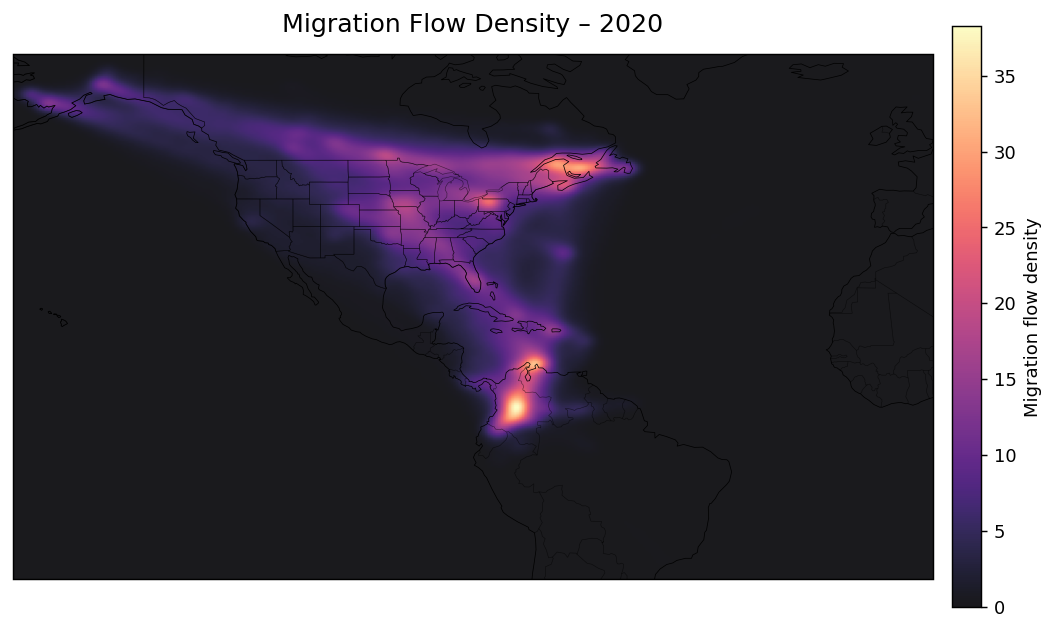

In [71]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter

# Select year and corresponding migration network
year = 2020
G = graphs_by_year[year]

# Store sampled longitude and latitude points
lons, lats = [], []

# Number of points sampled along each migration edge
N_SAMPLES = 20

# Interpolate evenly spaced points along each migration flow
for u, v, d in G.edges(data=True):
    u_data = G.nodes[u]
    v_data = G.nodes[v]

    for t in np.linspace(0, 1, N_SAMPLES):
        lons.append(u_data["centroid_lon"] * (1 - t) + v_data["centroid_lon"] * t)
        lats.append(u_data["centroid_lat"] * (1 - t) + v_data["centroid_lat"] * t)

lons = np.array(lons)
lats = np.array(lats)

# Compute data-driven geographic bounds with symmetric padding
lon_min, lon_max = lons.min(), lons.max()
lat_min, lat_max = lats.min(), lats.max()

lon_pad = 3
lat_pad = 3

extent = [
    lon_min - lon_pad,
    lon_max + lon_pad,
    lat_min - lat_pad,
    lat_max + lat_pad
]

# Create bins that exactly match the plotted extent
lon_bins = np.linspace(extent[0], extent[1], 350)
lat_bins = np.linspace(extent[2], extent[3], 300)

# Compute 2D spatial density histogram
H, _, _ = np.histogram2d(lons, lats, bins=[lon_bins, lat_bins])

# Smooth density to reveal continuous corridors
H = gaussian_filter(H, sigma=3)

# Create the map
plt.figure(figsize=(8, 5.8), dpi=130)
ax = plt.axes(projection=ccrs.PlateCarree())

# Let Cartopy control geographic aspect (prevents stretching)
ax.set_aspect("auto")

# Set map extent explicitly
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add geographic context
ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.3, alpha=0.6)

# Render the flow density map
im = ax.imshow(
    H.T,
    extent=extent,
    origin="lower",
    cmap="magma",
    alpha=0.9,
    transform=ccrs.PlateCarree()
)

# Add colorbar
plt.colorbar(
    im,
    ax=ax,
    fraction=0.03,
    pad=0.02,
    label="Migration flow density"
)

plt.title("Migration Flow Density – 2020", fontsize=14, pad=12)
plt.tight_layout(pad=0.3)
plt.show()


### Migration Flow Density Map (2020)

This map visualizes dominant migration corridors using a flow-density representation rather than direct edge plotting.  
For each migration flow, multiple points are sampled along the straight-line path between origin and destination centroids. These points are aggregated into a spatial grid and smoothed using a Gaussian filter to produce a continuous density field.

This approach avoids severe overplotting inherent in dense origin–destination networks and highlights large-scale migration corridors without imposing arbitrary edge or node thresholds. Brighter regions indicate areas through which a higher concentration of migration flows pass, revealing dominant spatial pathways of movement across the Americas.

The density represents relative flow intensity, not individual migration events or directions.

In [72]:
def compute_edge_persistence(graphs_by_year):
    """How many edges appear in consecutive years?"""
    years = sorted(graphs_by_year.keys())
    persistence = []
    
    for i in range(len(years)-1):
        G1 = graphs_by_year[years[i]]
        G2 = graphs_by_year[years[i+1]]
        
        edges1 = set(G1.edges())
        edges2 = set(G2.edges())
        
        persistence.append({
            'year': years[i],
            'persistent_edges': len(edges1 & edges2),
            'total_edges': len(edges1 | edges2),
            'jaccard': len(edges1 & edges2) / len(edges1 | edges2)
        })
    
    return pd.DataFrame(persistence)

EDGE PERSISTENCE ANALYSIS: Year-to-Year Migration Route Stability


,year,persistent_edges,total_edges,jaccard
0,2016,2795,9214,0.303343
1,2017,3052,10558,0.289070
2,2018,3578,10626,0.336721
3,2019,3410,10946,0.311529
4,2020,3565,11549,0.308685
5,2021,3992,12281,0.325055
6,2022,4604,12579,0.366007
7,2023,4508,12634,0.356815



SUMMARY STATISTICS
Average Jaccard similarity: 0.325
Minimum Jaccard similarity: 0.289 (year 2017)
Maximum Jaccard similarity: 0.366 (year 2022)

Average persistent edges: 3688.0
Average edge turnover: 67.5%


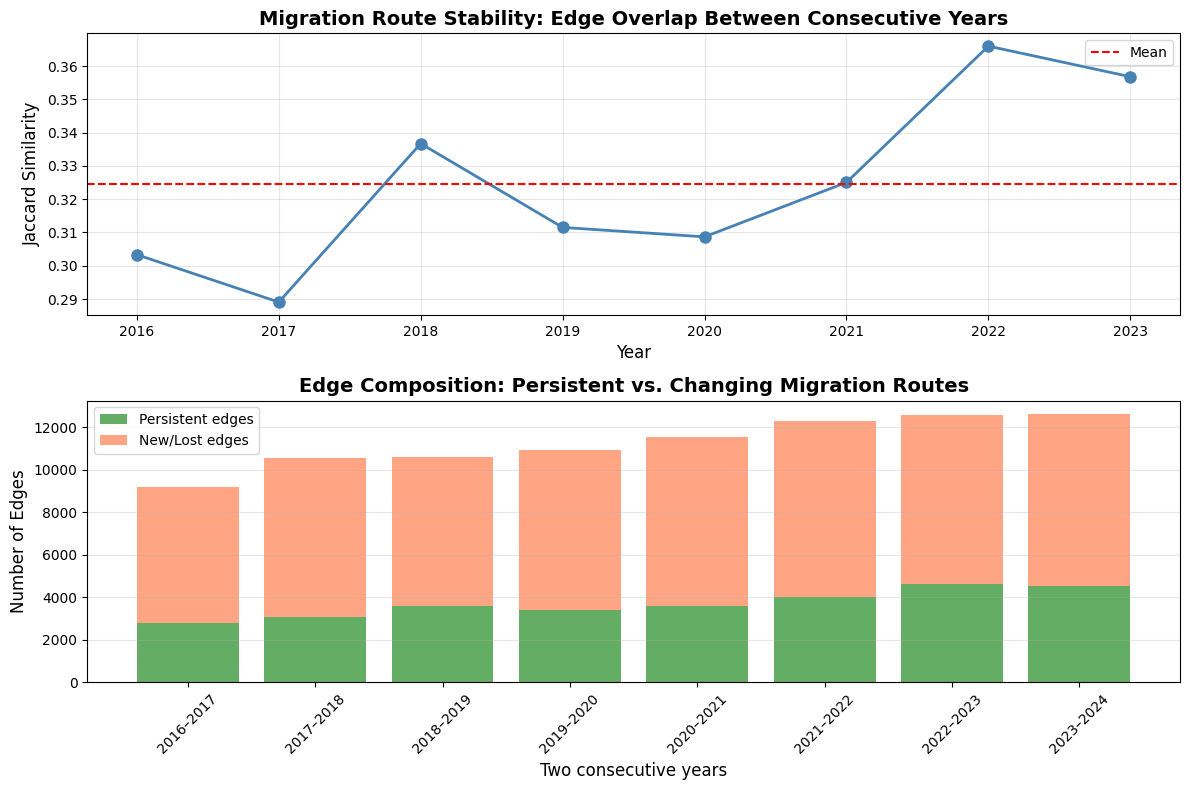

In [73]:
# Run the edge persistence analysis
persistence_df = compute_edge_persistence(graphs_by_year)

# Display the results
print("=" * 60)
print("EDGE PERSISTENCE ANALYSIS: Year-to-Year Migration Route Stability")
print("=" * 60)
display(persistence_df)

# Summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"Average Jaccard similarity: {persistence_df['jaccard'].mean():.3f}")
print(f"Minimum Jaccard similarity: {persistence_df['jaccard'].min():.3f} (year {persistence_df.loc[persistence_df['jaccard'].idxmin(), 'year']})")
print(f"Maximum Jaccard similarity: {persistence_df['jaccard'].max():.3f} (year {persistence_df.loc[persistence_df['jaccard'].idxmax(), 'year']})")
print(f"\nAverage persistent edges: {persistence_df['persistent_edges'].mean():.1f}")
print(f"Average edge turnover: {(1 - persistence_df['jaccard'].mean()) * 100:.1f}%")

# Visualize edge persistence over time
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Jaccard similarity over time
axes[0].plot(persistence_df['year'], persistence_df['jaccard'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(y=persistence_df['jaccard'].mean(), 
                color='red', linestyle='--', label='Mean')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Jaccard Similarity', fontsize=12)
axes[0].set_title('Migration Route Stability: Edge Overlap Between Consecutive Years', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Persistent vs New edges
year_pairs = [f"{y}–{y+1}" for y in persistence_df["year"]]
x = range(len(year_pairs))
persistence_df['new_or_lost_edges'] = persistence_df['total_edges'] - persistence_df['persistent_edges']

axes[1].bar(x, persistence_df['persistent_edges'], 
            label='Persistent edges', color='forestgreen', alpha=0.7)
axes[1].bar(x, persistence_df['new_or_lost_edges'], 
            bottom=persistence_df['persistent_edges'],
            label='New/Lost edges', color='coral', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels(year_pairs, rotation=45)
axes[1].set_xlabel('Two consecutive years', fontsize=12) 
axes[1].set_ylabel('Number of Edges', fontsize=12)
axes[1].set_title('Edge Composition: Persistent vs. Changing Migration Routes', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



Hubs are geographically stable (same regions year-to-year)
But connections between hubs are flexible (routes change)

## Node persistence

In [74]:
# Count years per node
node_years = defaultdict(set)

for year, G in graphs_by_year.items():
    for node in G.nodes():
        node_years[node].add(year)

node_persistence = pd.DataFrame({
    "cluster_id": list(node_years.keys()),
    "years_present": [len(yrs) for yrs in node_years.values()]
}).sort_values("years_present", ascending=False)

dist = (
    node_persistence["years_present"]
    .value_counts()
    .sort_index()
    .rename_axis("years_present")
    .to_frame("n_clusters")
)

dist["percent"] = 100 * dist["n_clusters"] / dist["n_clusters"].sum()
dist["cum_percent"] = dist["percent"].cumsum()

dist_display = dist.reset_index().style.format({
    "percent": "{:.2f}",
    "cum_percent": "{:.2f}"
})

display(dist_display)


,years_present,n_clusters,percent,cum_percent
0,1,58,7.15,7.15
1,2,87,10.73,17.88
2,3,125,15.41,33.29
3,4,88,10.85,44.14
4,5,65,8.01,52.16
5,6,92,11.34,63.50
6,7,57,7.03,70.53
7,8,73,9.00,79.53
8,9,166,20.47,100.00


Interpretation: counting how many clusters were seen in how many years

## Walk-based connectivity
Measuring indirect connectivity (structural properties, not behavioral trajectories)

In [75]:
walk_summary = []

for year, G in graphs_by_year.items():
    A = nx.to_numpy_array(G, weight="weight")
    n = A.shape[0]

    if n == 0:
        continue

    A2 = A @ A       # walks of length 2
    A3 = A2 @ A      # walks of length 3

    walk_summary.append({
        "year": year,
        "walk2_total": A2.sum() / n,
        "walk3_total": A3.sum() / n
    })

walk_df = pd.DataFrame(walk_summary).sort_values("year")
display(walk_df)


,year,walk2_total,walk3_total
0,2016,11.141877,68.943205
1,2017,9.997216,59.597366
2,2018,11.544154,75.641191
3,2019,10.831992,67.792481
4,2020,12.455566,85.776791
5,2021,11.396599,73.311440
6,2022,11.610217,76.106458
7,2023,11.265081,70.763875
8,2024,12.264795,82.587915


Interpretation: higher values → stronger indirect connectivity per region.

## Betweenness vs. in-strength comparison (node-level)

In [76]:
rows = []

for year, G in graphs_by_year.items():
    if G.number_of_nodes() == 0:
        continue

    betw = nx.betweenness_centrality(G, weight="weight", normalized=True)
    in_str = dict(G.in_degree(weight="weight"))

    for node in G.nodes():
        rows.append({
            "year": year,
            "cluster_id": node,
            "betweenness": betw.get(node, 0.0),
            "in_strength": in_str.get(node, 0.0)
        })


pd.set_option("display.float_format", "{:.6f}".format)
betw_vs_str = pd.DataFrame(rows)
str_vs_btw = pd.DataFrame(rows)


for year in sorted(betw_vs_str["year"].unique()):
    print(f"\nTop nodes by betweenness in year {year}:")
    df_betw = (
        betw_vs_str[betw_vs_str["year"] == year]
        .sort_values("betweenness", ascending=False)
        .head(10)
    )

    display(df_betw)

for year in sorted(betw_vs_str["year"].unique()):
    print(f"mean betweenness in {year}:", betw_vs_str[betw_vs_str["year"] == year]["betweenness"].mean())

for year in sorted(str_vs_btw["year"].unique()):
    print(f"\nTop nodes by in-strength in year {year}:")
    df_str = (
        str_vs_btw[str_vs_btw["year"] == year]
        .sort_values("in_strength", ascending=False)
        .head(10)
    )

    display(df_str)

for year in sorted(str_vs_btw["year"].unique()):
    print(f"mean in-strength in {year}:", str_vs_btw[str_vs_btw["year"] == year]["in_strength"].mean())
    


Top nodes by betweenness in year 2016:


,year,cluster_id,betweenness,in_strength
81,2016,191,0.059316,0.297239
7,2016,16,0.043416,1.864637
224,2016,486,0.034044,4.724805
327,2016,744,0.015937,10.893320
156,2016,307,0.010854,0.515717
258,2016,567,0.009933,0.371248
80,2016,190,0.006535,0.944531
107,2016,222,0.004858,4.314801
349,2016,779,0.004574,1.826410
276,2016,602,0.004147,3.604172



Top nodes by betweenness in year 2017:


,year,cluster_id,betweenness,in_strength
625,2017,496,0.033910,13.578288
434,2017,137,0.032632,8.153403
449,2017,178,0.030992,19.124510
584,2017,420,0.020631,0.963408
457,2017,190,0.016548,0.356837
678,2017,585,0.015898,0.100451
532,2017,307,0.008483,0.166046
389,2017,40,0.006996,3.994060
783,2017,806,0.005995,2.450042
497,2017,245,0.005395,0.101842



Top nodes by betweenness in year 2018:


,year,cluster_id,betweenness,in_strength
1081,2018,486,0.042650,4.257239
880,2018,178,0.032050,19.735333
1072,2018,473,0.022083,0.154856
805,2018,30,0.020389,56.946103
1088,2018,499,0.016584,2.612408
1059,2018,448,0.008043,37.079870
1239,2018,799,0.008033,0.803833
794,2018,13,0.006512,20.668137
822,2018,62,0.005806,0.255924
938,2018,253,0.004050,0.141135



Top nodes by betweenness in year 2019:


,year,cluster_id,betweenness,in_strength
1301,2019,99,0.029805,0.859201
1515,2019,467,0.027005,3.647440
1305,2019,105,0.015305,5.049200
1669,2019,727,0.010525,4.495934
1540,2019,499,0.009504,3.024192
1322,2019,137,0.006835,16.195695
1285,2019,76,0.006609,0.145833
1708,2019,798,0.005683,5.980410
1282,2019,64,0.004608,0.243056
1260,2019,30,0.004165,73.730963



Top nodes by betweenness in year 2020:


,year,cluster_id,betweenness,in_strength
2175,2020,741,0.032321,2.137095
1735,2020,30,0.022496,75.629385
1780,2020,112,0.021150,0.272681
2052,2020,491,0.020364,0.088660
2120,2020,613,0.020342,0.094904
2057,2020,499,0.016673,1.346203
1729,2020,19,0.007553,3.730723
1988,2020,390,0.007282,6.960529
2044,2020,475,0.004937,7.614658
1765,2020,86,0.004093,0.292683



Top nodes by betweenness in year 2021:


,year,cluster_id,betweenness,in_strength
2207,2021,30,0.042398,68.769857
2517,2021,499,0.038345,0.475251
2502,2021,475,0.032417,3.470323
2415,2021,342,0.009487,0.272550
2297,2021,178,0.009146,16.031399
2692,2021,798,0.008736,8.350076
2574,2021,585,0.008473,0.274713
2213,2021,39,0.006199,2.354290
2394,2021,307,0.003987,0.145745
2381,2021,288,0.003601,0.084626



Top nodes by betweenness in year 2022:


,year,cluster_id,betweenness,in_strength
3177,2022,729,0.027321,4.277591
2772,2022,116,0.019520,8.379209
3021,2022,477,0.013578,0.646036
3094,2022,576,0.011842,0.172471
2959,2022,390,0.007540,5.751472
3119,2022,613,0.006359,0.086223
2765,2022,105,0.006140,21.274957
3030,2022,491,0.006094,0.187265
2810,2022,178,0.005073,19.327482
2792,2022,148,0.004754,4.063374



Top nodes by betweenness in year 2023:


,year,cluster_id,betweenness,in_strength
3321,2023,116,0.021983,4.058613
3567,2023,463,0.021076,7.646085
3463,2023,307,0.016803,1.856541
3577,2023,475,0.012661,0.803279
3598,2023,499,0.009790,0.559052
3481,2023,337,0.007721,0.118283
3266,2023,40,0.005620,0.882943
3363,2023,178,0.004088,21.374758
3247,2023,17,0.003254,3.037814
3273,2023,49,0.002858,0.963211



Top nodes by betweenness in year 2024:


,year,cluster_id,betweenness,in_strength
4217,2024,632,0.024497,1.653329
3809,2024,30,0.022370,67.158669
3869,2024,112,0.015638,0.912748
4051,2024,390,0.013003,14.836821
4109,2024,475,0.011607,1.150190
4067,2024,420,0.011290,3.482053
4127,2024,499,0.011287,1.119339
3991,2024,288,0.010971,0.151799
3858,2024,99,0.005093,2.104938
3791,2024,6,0.004260,0.480769


mean betweenness in 2016: 0.0006069039170441587
mean betweenness in 2017: 0.0005274461778947826
mean betweenness in 2018: 0.00041542886675950485
mean betweenness in 2019: 0.0003175334186265345
mean betweenness in 2020: 0.0003684203071320888
mean betweenness in 2021: 0.00035755202100950834
mean betweenness in 2022: 0.0002565927963657695
mean betweenness in 2023: 0.00023221044979902393
mean betweenness in 2024: 0.00028252429465676495

Top nodes by in-strength in year 2016:


,year,cluster_id,betweenness,in_strength
108,2016,223,0.000674,341.927610
187,2016,390,0.000000,64.294000
210,2016,448,0.000000,38.070887
44,2016,105,0.001699,27.772830
71,2016,178,0.000000,20.334899
308,2016,707,0.000000,18.415192
50,2016,116,0.002014,16.956752
14,2016,30,0.000000,14.142673
4,2016,13,0.000000,14.072341
327,2016,744,0.015937,10.893320



Top nodes by in-strength in year 2017:


,year,cluster_id,betweenness,in_strength
482,2017,223,0.000011,343.669935
571,2017,390,0.000990,66.946268
600,2017,448,0.000051,29.074880
751,2017,744,0.000000,28.166475
375,2017,13,0.000000,28.045765
449,2017,178,0.030992,19.124510
383,2017,30,0.000000,17.854199
423,2017,112,0.000622,15.144779
420,2017,105,0.000607,15.113259
425,2017,116,0.000000,13.622557



Top nodes by in-strength in year 2018:


,year,cluster_id,betweenness,in_strength
918,2018,223,0.000295,485.333953
805,2018,30,0.020389,56.946103
1059,2018,448,0.008043,37.079870
1021,2018,390,0.000288,36.216013
1213,2018,744,0.000000,21.193042
794,2018,13,0.006512,20.668137
880,2018,178,0.032050,19.735333
1086,2018,496,0.000456,17.310104
1192,2018,707,0.000000,14.027080
797,2018,16,0.000000,10.827062



Top nodes by in-strength in year 2019:


,year,cluster_id,betweenness,in_strength
1373,2019,223,0.000000,464.275905
1260,2019,30,0.004165,73.730963
1501,2019,448,0.000126,37.735559
1681,2019,744,0.000000,31.706920
1463,2019,390,0.002259,20.555593
1530,2019,486,0.000005,17.150096
1538,2019,496,0.000099,16.516846
1322,2019,137,0.006835,16.195695
1342,2019,178,0.001581,13.289203
1253,2019,16,0.000000,10.394192



Top nodes by in-strength in year 2020:


,year,cluster_id,betweenness,in_strength
1855,2020,223,0.000000,565.236255
1735,2020,30,0.022496,75.629385
2026,2020,448,0.000000,53.046503
1819,2020,178,0.000673,22.433001
2050,2020,486,0.000000,17.415957
2055,2020,496,0.000000,15.637340
2177,2020,744,0.000000,15.078710
1724,2020,13,0.000000,9.229024
2044,2020,475,0.004937,7.614658
1988,2020,390,0.007282,6.960529



Top nodes by in-strength in year 2021:


,year,cluster_id,betweenness,in_strength
2331,2021,223,0.000000,530.922748
2207,2021,30,0.042398,68.769857
2481,2021,448,0.000000,51.026940
2661,2021,744,0.000000,42.822492
2508,2021,486,0.000000,24.555031
2515,2021,496,0.000000,20.310103
2274,2021,137,0.000000,18.140398
2297,2021,178,0.009146,16.031399
2210,2021,33,0.000000,12.671764
2493,2021,463,0.000124,12.296925



Top nodes by in-strength in year 2022:


,year,cluster_id,betweenness,in_strength
2845,2022,223,0.000000,527.842488
2721,2022,30,0.000000,78.558209
2999,2022,448,0.000007,65.892359
3035,2022,496,0.000000,45.730219
3190,2022,744,0.000000,32.642408
3028,2022,486,0.000000,27.508619
2765,2022,105,0.006140,21.274957
2810,2022,178,0.005073,19.327482
2708,2022,13,0.000000,16.429732
3163,2022,707,0.000000,12.551575



Top nodes by in-strength in year 2023:


,year,cluster_id,betweenness,in_strength
3400,2023,223,0.000000,483.916402
3258,2023,30,0.000000,83.078216
3557,2023,448,0.001079,70.955912
3595,2023,496,0.000000,54.286508
3244,2023,13,0.000000,31.601972
3747,2023,744,0.001779,29.896298
3587,2023,486,0.000000,25.187100
3363,2023,178,0.004088,21.374758
3399,2023,222,0.001683,18.395890
3261,2023,33,0.000112,17.340124



Top nodes by in-strength in year 2024:


,year,cluster_id,betweenness,in_strength
3950,2024,223,0.000000,468.377987
4088,2024,448,0.000015,81.990687
3809,2024,30,0.022370,67.158669
4125,2024,496,0.000000,49.662543
4278,2024,744,0.000000,34.168978
4118,2024,486,0.000000,32.361513
3795,2024,13,0.000000,32.187645
3800,2024,19,0.000000,27.304196
3919,2024,178,0.000000,17.578517
3797,2024,16,0.000073,14.981123


mean in-strength in 2016: 1.7754204034901804
mean in-strength in 2017: 1.6692499155852587
mean in-strength in 2018: 1.770954896111772
mean in-strength in 2019: 1.729840572201008
mean in-strength in 2020: 1.8091554479053062
mean in-strength in 2021: 1.7827690733811823
mean in-strength in 2022: 1.8016770924981256
mean in-strength in 2023: 1.800956587398774
mean in-strength in 2024: 1.8397287297346934


## Weighted betweenness centrality (bottlenecks per year)

In [77]:
bottlenecks = []

for year, G in graphs_by_year.items():
    if G.number_of_nodes() < 3:
        continue

    betw = nx.betweenness_centrality(G, weight="weight", normalized=True)

    df_year = (
        pd.DataFrame({
            "cluster_id": list(betw.keys()),
            "betweenness": list(betw.values())
        })
        .assign(year=year)
        .sort_values("betweenness", ascending=False)
    )

    # keep top 5% as bottlenecks
    cutoff = df_year["betweenness"].quantile(0.95)
    bottlenecks.append(df_year[df_year["betweenness"] >= cutoff])

bottlenecks_df = pd.concat(bottlenecks, ignore_index=True)
sorted_bottlenecks = bottlenecks_df.sort_values(by=["year", "betweenness"], ascending=[True, False])

for year in sorted_bottlenecks["year"].unique():
    print(f"\nBottleneck clusters in year {year}:")
    df_year = sorted_bottlenecks[sorted_bottlenecks["year"] == year]
    display(df_year)


Bottleneck clusters in year 2016:


,cluster_id,betweenness,year
0,191,0.059316,2016
1,16,0.043416,2016
2,486,0.034044,2016
3,744,0.015937,2016
4,307,0.010854,2016
5,567,0.009933,2016
6,190,0.006535,2016
7,222,0.004858,2016
8,779,0.004574,2016
9,602,0.004147,2016



Bottleneck clusters in year 2017:


,cluster_id,betweenness,year
19,496,0.033910,2017
20,137,0.032632,2017
21,178,0.030992,2017
22,420,0.020631,2017
23,190,0.016548,2017
24,585,0.015898,2017
25,307,0.008483,2017
26,40,0.006996,2017
27,806,0.005995,2017
28,245,0.005395,2017



Bottleneck clusters in year 2018:


,cluster_id,betweenness,year
41,486,0.042650,2018
42,178,0.032050,2018
43,473,0.022083,2018
44,30,0.020389,2018
45,499,0.016584,2018
46,448,0.008043,2018
47,799,0.008033,2018
48,13,0.006512,2018
49,62,0.005806,2018
50,253,0.004050,2018



Bottleneck clusters in year 2019:


,cluster_id,betweenness,year
64,99,0.029805,2019
65,467,0.027005,2019
66,105,0.015305,2019
67,727,0.010525,2019
68,499,0.009504,2019
69,137,0.006835,2019
70,76,0.006609,2019
71,798,0.005683,2019
72,64,0.004608,2019
73,30,0.004165,2019



Bottleneck clusters in year 2020:


,cluster_id,betweenness,year
88,741,0.032321,2020
89,30,0.022496,2020
90,112,0.021150,2020
91,491,0.020364,2020
92,613,0.020342,2020
93,499,0.016673,2020
94,19,0.007553,2020
95,390,0.007282,2020
96,475,0.004937,2020
97,86,0.004093,2020



Bottleneck clusters in year 2021:


,cluster_id,betweenness,year
112,30,0.042398,2021
113,499,0.038345,2021
114,475,0.032417,2021
115,342,0.009487,2021
116,178,0.009146,2021
117,798,0.008736,2021
118,585,0.008473,2021
119,39,0.006199,2021
120,307,0.003987,2021
121,288,0.003601,2021



Bottleneck clusters in year 2022:


,cluster_id,betweenness,year
138,729,0.027321,2022
139,116,0.019520,2022
140,477,0.013578,2022
141,576,0.011842,2022
142,390,0.007540,2022
143,613,0.006359,2022
144,105,0.006140,2022
145,491,0.006094,2022
146,178,0.005073,2022
147,148,0.004754,2022



Bottleneck clusters in year 2023:


,cluster_id,betweenness,year
165,116,0.021983,2023
166,463,0.021076,2023
167,307,0.016803,2023
168,475,0.012661,2023
169,499,0.009790,2023
170,337,0.007721,2023
171,40,0.005620,2023
172,178,0.004088,2023
173,17,0.003254,2023
174,49,0.002858,2023



Bottleneck clusters in year 2024:


,cluster_id,betweenness,year
193,632,0.024497,2024
194,30,0.022370,2024
195,112,0.015638,2024
196,390,0.013003,2024
197,475,0.011607,2024
198,420,0.011290,2024
199,499,0.011287,2024
200,288,0.010971,2024
201,99,0.005093,2024
202,6,0.004260,2024


Interpretation: regions whose removal would most disrupt migration connectivity

## Node removal
- Random node removal
- Removal of nodes with high betweenness
- Removal of nodes with high in-strength

-> Compare the metrics of all three cases

In [78]:
def compute_vulnerability_metrics(G: nx.DiGraph, total_clusters: int) -> dict:
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    if n == 0 or m == 0:
        return {
            "n_nodes": n,
            "n_edges": m,
            "lwcc_ratio": 0.0,
            "total_in_strength": 0.0,
            "mean_in_strength": np.nan,
            "max_in_strength": np.nan,
            "avg_path_length": np.nan,
            "path_90th": np.nan,
            "diameter": np.nan
        }
    
    # Compute largest weakly connected component size
    lwcc_nodes = max(nx.weakly_connected_components(G), key=len)
    lwcc_ratio = len(lwcc_nodes) / total_clusters

    # Compute in_strength distribution
    in_strength = np.array([s for _, s in G.in_degree(weight="weight")], dtype = float)

    # Compute average path length in the LWCC
    # Undirected distances on the undirected LWCC
    Gu = G.to_undirected(as_view=False)
    lwcc_u = max(nx.connected_components(Gu), key=len)
    Hu = Gu.subgraph(lwcc_u).copy()

    path_lengths = []
    spl = dict(nx.all_pairs_shortest_path_length(Hu))
    for source in spl:
        for target, dist in spl[source].items():
            if source != target:
                path_lengths.append(dist)

    if path_lengths:
        avg_path_length = float(np.mean(path_lengths))
        path_90th = float(np.percentile(path_lengths, 90))
        diameter = float(np.max(path_lengths))
    else:
        avg_path_length = np.nan
        path_90th = np.nan
        diameter = np.nan



    return{
        "n_nodes": n,
        "n_edges": m,
        "lwcc_ratio": lwcc_ratio,
        "total_in_strength": in_strength.sum(),
        "mean_in_strength": in_strength.mean() if in_strength.size > 0 else np.nan,
        "max_in_strength": in_strength.max() if in_strength.size > 0 else np.nan,
        "avg_path_length": avg_path_length,
        "path_90th": path_90th,
        "diameter": diameter
    }

def node_removal(graphs_by_year: dict, cluster_nodes, seed=None) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    total_clusters = cluster_nodes.shape[0]
    removal_summary = []

    for year in sorted(graphs_by_year.keys()):
        G = graphs_by_year[year]
        if G.number_of_nodes() == 0:
            continue

        base = compute_vulnerability_metrics(G, total_clusters)
        removal_summary.append({
            "year": year,
            "strategy": "baseline",
            "node_removed": None,
            **base
        })

        nodes = list(G.nodes())
        if not nodes:
            continue

        # Remove random node
        random_node = rng.choice(nodes)

        # Remove highest in-strength node
        in_strength = dict(G.in_degree(weight="weight"))
        max_in_node = max(in_strength, key=in_strength.get)

        # Remove highest betweenness node
        betw = nx.betweenness_centrality(G, weight="weight", normalized=True)
        max_betw_node = max(betw, key=betw.get)

        removal = [
            ("remove_random", random_node),
            ("remove_max_in_strength", max_in_node),
            ("remove_max_betweenness", max_betw_node),
        ]

        for strategy, node_to_remove in removal:
            G2 = G.copy()
            if node_to_remove in G2:
                G2.remove_node(node_to_remove)

            metrics = compute_vulnerability_metrics(G2, total_clusters)
            removal_summary.append({
                "year": year,
                "strategy": strategy,
                "node_removed": node_to_remove,
                **metrics
            })

    return pd.DataFrame(removal_summary)

nodes_df = nodes_bkpwar
vulnerability_df = node_removal(graphs_by_year, cluster_nodes=nodes_df, seed=42)
display(vulnerability_df.sort_values(["year", "strategy"]).reset_index(drop=True))
    

,year,strategy,node_removed,n_nodes,n_edges,lwcc_ratio,total_in_strength,mean_in_strength,max_in_strength,avg_path_length,path_90th,diameter
0,2016,baseline,NaN,367,5474,0.449755,651.579288,1.775420,341.927610,1.939474,2.000000,3.000000
1,2016,remove_max_betweenness,191.000000,366,5309,0.448529,648.585715,1.772092,341.182127,1.941403,2.000000,3.000000
2,2016,remove_max_in_strength,223.000000,366,5076,0.448529,306.117752,0.836387,63.545918,2.040093,3.000000,3.000000
3,2016,remove_random,82.000000,366,5448,0.448529,648.800867,1.772680,341.488194,1.939531,2.000000,3.000000
4,2017,baseline,NaN,422,6535,0.517157,704.423464,1.669250,343.669935,1.945548,2.000000,3.000000
5,2017,remove_max_betweenness,496.000000,421,6218,0.515931,686.335109,1.630250,341.017208,1.948603,2.000000,3.000000
6,2017,remove_max_in_strength,223.000000,421,6072,0.515931,357.103762,0.848227,66.165362,2.053931,3.000000,3.000000
7,2017,remove_random,608.000000,421,6525,0.515931,703.540971,1.671119,343.243107,1.945346,2.000000,3.000000
8,2018,baseline,NaN,458,7075,0.561275,811.097342,1.770955,485.333953,1.960297,2.000000,3.000000
9,2018,remove_max_betweenness,486.000000,457,6740,0.560049,802.288588,1.755555,482.159848,1.963108,2.000000,3.000000
